# Invoice reading NLP system
Remember this image? IT IS BACK!!!
![System image](https://storage.googleapis.com/aibootcamp/general_assets/ml_system_architecture.png)


This week is all about system building. Because hardly ever does a ML system stand alone. Your success in building a system for Ortec Finance depends as much on what is around your neural net as it depends on the neural net itself. This baseline is my approach to the problem. Much in this notebook was hacked together so I am sure you can improve on many points. Perhaps you even come up with a completely different approach.

## The approach, character wise classification:
The goal of the task is to extract information from the invoice. The invoice has been run through optical character recognition (OCR). OCR turns PDFs into texts but often messes up the order and confuses come characters. **To extract information from this text, we classify each character by category**. 

Take an example, if we just wanted to get the amount we would classify the characters like this:

|T|O|T|A|L|:| |€| |4|3|6|.|0|0|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|0|0|0|0|0|0|0|1|1|1|1|1|1|1|1|

We classify our text into 6 classes here:

Ignore:           0
Sender Name:      1 
Sender KVK:       2 
Sender IBAN:      3 
Invoice Reference:4
Total:            5

These are the classes that the training data generator tags. But the class of a character does not only depend on the character. It depends on its surroundings as well. To train our model, we create substrings of our invoice that include a certain amount of preceeding and succeeding characters. The amount of preceding and succeeding characters is defined in the `PADDING` global variable. 

If for example we wanted to classify the character '€' from the example above and had `PADDING = 3` we would feed
'L: € 43' into our network. You can see how the amount of padding has a great influence on the performance of our system.

## Post processing:
A significant part of model performance stems from what is done with the outputs of the neural net. This approach groups predictions to prediction sequences and only keeps predictions in which 5 consecutive characters were grouped into the same category. An approach to try would be to allow sequences to be interrupted by one character. Another nice add on would be to rank predicted sequences by the total confidence the neural network has in the sequence. 

## Some tips:
For this assignment you can dive pretty deep into software development. 
You might find these jupyter tricks helpful: https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/

Especially debugging with `pdb` really makes things easier: https://docs.python.org/3.5/library/pdb.html#debugger-commands

Basically, if anything crashes, you can start a new cell and enter `%debug`. You then come to a command line in which you can look around what happened at the crash.
The debugger has some special commands. For example `p my_var` prints out a variable. This also works for other python operations, e.g. `p len(my_list)`.

Good luck with building a great system!

In [1]:
# Setup 
!wget https://storage.googleapis.com/aibootcamp/data/ortec_templates_updated.zip

--2018-03-19 20:21:50--  https://storage.googleapis.com/aibootcamp/data/ortec_templates_updated.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.28.128, 2607:f8b0:400e:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.28.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20419 (20K) [application/zip]
Saving to: ‘ortec_templates_updated.zip’

ortec_templates_upd 100%[===================>]  19.94K  --.-KB/s    in 0s      

2018-03-19 20:21:50 (61.8 MB/s) - ‘ortec_templates_updated.zip’ saved [20419/20419]



In [1]:
!ls

datalab  __MACOSX  ortec_templates_updated.zip	templates


In [3]:
!unzip ortec_templates_updated.zip

Archive:  ortec_templates_updated.zip
   creating: templates/
  inflating: templates/.DS_Store     
   creating: __MACOSX/
   creating: __MACOSX/templates/
  inflating: __MACOSX/templates/._.DS_Store  
  inflating: templates/invoicegen.py  
  inflating: __MACOSX/templates/._invoicegen.py  
   creating: templates/__pycache__/
  inflating: templates/__pycache__/invoicegen.cpython-35.pyc  
   creating: templates/.ipynb_checkpoints/
  inflating: templates/.ipynb_checkpoints/Untitled1-checkpoint.ipynb  
  inflating: templates/.ipynb_checkpoints/Untitled-checkpoint.ipynb  
  inflating: templates/.ipynb_checkpoints/Baseline Ortec-checkpoint.ipynb  
  inflating: templates/TEMPLATE_1.txt  
  inflating: __MACOSX/templates/._TEMPLATE_1.txt  
  inflating: templates/TEMPLATE_2.txt  
  inflating: __MACOSX/templates/._TEMPLATE_2.txt  


In [4]:
!ls

datalab  __MACOSX  ortec_templates_updated.zip	templates


In [0]:
!pip install -q keras

## Loading templates

In [0]:
# System hyper parameters here

# How many characters before and after the main char to feed the NN
PADDING = 20 


'''
Ignore:           0
Sender Name:      1 
Sender KVK:       2 
Sender IBAN:      3 
Invoice Reference:4
Total:            5
'''
N_CLASSES = 6

In [0]:
# Invoice data generator
from templates.invoicegen import create_invoice

In [4]:

# Your friendly tokenizer
from keras.preprocessing.text import Tokenizer

# Numpy
import numpy as np

#Pandas of course too
import pandas as pd

Using TensorFlow backend.


In [0]:
# Create 100 invoices for each template

invoices = []
targets = []

# Load template 1
with open('templates/TEMPLATE_1.txt', 'r') as content_file:
    content = content_file.read()

# Create invoices from template
for i in range(100):
    inv, tar = create_invoice(content)
    invoices.append(inv)
    targets.append(tar)
    
# Load template 2
with open('templates/TEMPLATE_2.txt', 'r') as content_file:
    content = content_file.read()
    
# Create invoices from template
for i in range(100):
    inv, tar = create_invoice(content)
    invoices.append(inv)
    targets.append(tar)

In [6]:
len(targets)

200

## Generate substring

In [0]:
# Create our tokenizer
# We will tokenize on character level!
# We will NOT remove any characters
tokenizer = Tokenizer(char_level=True, filters=None)
tokenizer.fit_on_texts(invoices)

In [0]:
def gen_sub(inv,tar,pad, m = None):
    '''
    Generates a substring from invoice inv and target list tar 
    using the character at index m as a midpoint.
    
    Params:
    inv - an invoice string
    tar - a target list specifying the type of each item
    pad - the amount of padding to attach before and after the focus character
    
    Returns:
    sub - a string with pad characters, the focus character, pad characters
    '''
    # If no focus character index is set, choose at random
    if m == None:
        m = np.random.randint(0,len(inv))
        
    l = m - pad # define the lower bound of our substring
    h = m + pad + 1 # define the upper (high) of our substring

    # Sometimes, our lower bound could be below zero
    # In this case we attach the remaining characters from the back of the string
    if l < 0:
        s1 = ''.zfill(-1*l)
        s2 = inv[None:h]
        # Create substring
        sub = s1 + s2
        
        # Ensure the substring has the right length
        assert(len(sub) == pad*2 +1)
        return sub, tar[m]
    
    # Our lower bound might be positive but our upper bound might 
    # still be above the length of the invoice
    elif h >= len(inv):
        # Calc how many chars are too much
        overlap = h - len(inv)
        # Get string from lower bound to end
        s1 = inv[l:None]
        # Get string from the front of the doc
        s2 = ''.zfill(overlap)
        sub = s1 + s2
        # Make sure our string has the correct length
        assert(len(sub) == pad*2 +1)
        return sub, tar[m]
    
    # Upper and lower bound lie within the length of the invoice
    else: 
        sub = inv[l:h]
        assert(len(sub) == pad*2 +1)
        return sub, tar[m]

## Generate dataset for training

In [0]:
def gen_dataset(sample_size, n_classes, invoices, targets, tokenizer):
    '''
    Generate a dataset of inputs and outputs for our neural network
    
    Params:
    sample_size - desired sample size
    n_classes - number of classes
    invoices - list of invoices to sample from
    targets - list of corresonding targets to sample from
    tokenizer - a keras tokenizer fit on the invoices
    
    The function creates balanced samples by randomly sampling untill 
    an equal amount of samples of all types is created.
    
    Characters are one hot encoded
    
    Returns:
    x_arr: a numpy array of shape (sample_size, seqence length, number of unique characters)
    y_arr: a numpy array of shape (sample_size,)
    '''
    
    # Create a budget
    budget = [sample_size / n_classes] * n_classes
    
    # Setup holding variables
    X_train = []
    y_train = []

    # While there is still a budget left...
    while sum(budget) > 0:
        # ... get a random invoice and target list
        index = np.random.randint(0,len(invoices))
        inv = invoices[index]
        tar = targets[index]
        # ... sample up to 10 items from this invoice 
        for j in range(10):
            # Get an item
            x, y = gen_sub(inv,tar,PADDING)
            # if we still have a budget for this items target
            if budget[y] > 0:
                # Tokenize to one hot
                xm = tokenizer.texts_to_matrix(x)
                # Add data and target
                X_train.append(xm)
                y_train.append(y)
                budget[y] -= 1
      
    # Create numpy arrays from all data and targets
    x_arr = np.array(X_train)
    y_arr = np.array(y_train)
    return x_arr,y_arr

In [0]:
# Ger data
train_size = 12000
val_size = 120

x_tr, y_tr = gen_dataset(train_size, N_CLASSES, invoices, targets, tokenizer)
x_val, y_val = gen_dataset(val_size, N_CLASSES, invoices, targets, tokenizer)

In [11]:
x_tr.shape

(12000, 41, 83)

## Model building

In [0]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense,Activation, Conv1D, MaxPool1D,LSTM

In [0]:
# Model to recognize types
model = Sequential()
model.add(Conv1D(63,2,input_shape=(None,83)))
model.add(MaxPool1D(2))
model.add(Conv1D(42,2))
model.add(MaxPool1D(2))
model.add(LSTM(20))
model.add(Dense(6))
model.add(Activation('softmax'))

In [0]:
# sparse_categorical_crossentropy is like categorical crossentropy but without converting targets to one hot
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam', metrics=['acc'])

In [19]:
#Not to many epochs (avoid overfitting)
model.fit(x_tr,y_tr,batch_size=32,epochs=8,validation_data=(x_val,y_val))

Train on 12000 samples, validate on 120 samples
Epoch 1/8
12000/12000 [==============================] - 6s 504us/step - loss: 0.3104 - acc: 0.9229 - val_loss: 0.0897 - val_acc: 0.9750
Epoch 2/8
12000/12000 [==============================] - 6s 481us/step - loss: 0.0506 - acc: 0.9878 - val_loss: 0.0960 - val_acc: 0.9750
Epoch 3/8
12000/12000 [==============================] - 6s 505us/step - loss: 0.0272 - acc: 0.9942 - val_loss: 0.0675 - val_acc: 0.9917
Epoch 4/8
 2880/12000 [======>.......................] - ETA: 4s - loss: 0.0208 - acc: 0.9955

12000/12000 [==============================] - 6s 501us/step - loss: 0.0222 - acc: 0.9951 - val_loss: 0.0751 - val_acc: 0.9833
Epoch 5/8
12000/12000 [==============================] - 6s 496us/step - loss: 0.0200 - acc: 0.9952 - val_loss: 0.0518 - val_acc: 0.9917
Epoch 6/8
12000/12000 [==============================] - 6s 500us/step - loss: 0.0141 - acc: 0.9966 - val_loss: 0.0616 - val_acc: 0.9917
Epoch 7/8
 8160/12000 [===================>..........] - ETA: 1s - loss: 0.0097 - acc: 0.9979

12000/12000 [==============================] - 6s 479us/step - loss: 0.0094 - acc: 0.9980 - val_loss: 0.0578 - val_acc: 0.9917
Epoch 8/8
12000/12000 [==============================] - 6s 488us/step - loss: 0.0104 - acc: 0.9975 - val_loss: 0.0617 - val_acc: 0.9917


## Generate demo invoice

In [20]:
'''
To make predictions from our model, we need to create 
sequences around every character from the invoice.

We the making predictions for every charater based on their invoice
'''

def get_invoice(specific=-1):
    if(specific>-1):
        index = specific
    else:
        # Choose a random invoice:
        index = np.random.randint(0,len(invoices))
    inv = invoices[index]
    tar = targets[index]


    chars = [] # Holds the individual characters
    data_seq = [] # Holds the sequences around the characters
    y_actual = [] # Holds the true targets for each character

    # Loop over characters indices
    for i in range(len(inv) -1):
        # Create sequence around this character
        x,y = gen_sub(inv,tar,PADDING,m=i)
        # Tokenize the sequence to one hot
        xm = tokenizer.texts_to_matrix(x)
        # Get the character itself
        c = inv[i]

        chars.append(c)
        data_seq.append(xm)
        y_actual.append(y)
    return chars, data_seq, y_actual

# Look at specific invoice
characters,data, y_true = get_invoice(100)

# For demo purposes we can look what our invoice looks like
df = pd.DataFrame({'Char':characters,'Target':y_true})

# Show all characters belonging to the amount
df[df.Target == 5]

,Char,Target
308,1,5
309,7,5
310,0,5
311,5,5
312,0,5
313,.,5
314,7,5
315,7,5


## Making predictions

In [0]:
#Generate prediction from data
def get_preds(data):
    x_test = np.array(data)
    #print(x_test.shape)
    # Make predictions
    y_pred = model.predict(x_test)

    # Get the maximum likely class
    y_pred = y_pred.argmax(axis=1)

    # Show how our model predictions look like
    #df['Predicted'] = y_pred

    # Show all chars that are predicted to belong to the amount
    #df[df.Predicted == 5]
    
    return y_pred

y_pred = get_preds(data)# Create test data for predictions with neural net

In [22]:
#Function to group the target observations into one dataframe
def melt_info(inv, pred,cut_off=0):
    cut_off=int(cut_off)
    fromIdx = []
    toIdx = []
    types = []
    fromIdx.append(0)
    lastType = pred[0]
    types.append(lastType)
    # Loop over the target values to get groups
    for i in range(len(inv) -1):
        curType = pred[i]
        if(curType != lastType):
            toIdx.append(i)
            fromIdx.append(i)
            types.append(curType)
            lastType = curType
    toIdx.append(len(inv)-1)
    melted = pd.DataFrame({'From':fromIdx,'To':toIdx,'Type':types})
    melted['length'] = [row['To']-row['From'] for idx, row in melted.iterrows()]
    melted['Text'] = [inv[row['From']:row['To']] for idx, row in melted.iterrows()]
    if(cut_off>0):
        for index, row in melted.iterrows():
            if(row['length']<cut_off+1):
                pred[row['From']:row['To']] = 0
        return melt_info(inv, pred)
    else:
        return melted, pred

melted,preds = melt_info(characters,y_pred,0)
display(melted)


,From,To,Type,length,Text
0,0,127,0,127,"[A, m, a, z, o, n, , W, e, b, , S, e, r, v, ..."
1,127,128,4,1,[:]
2,128,129,0,1,[\n]
3,129,139,4,10,"[\n, B, D, S, 9, G, \n, B, i, l]"
4,139,140,0,1,[l]
5,140,141,4,1,[ ]
6,141,177,0,36,"[t, o, , A, d, d, r, e, s, s, :, \n, \n, A, T..."
7,177,178,1,1,[.]
8,178,185,0,7,"[\n, B, o, o, m, p, j]"
9,185,186,1,1,[e]


In [0]:
# Method to clean the names in the categorisation.
def cleanNames(inv,pred,melted):
    #Find one name only
    found_name = False
    #Iterate over rows
    for index, row in melted.iterrows():
        #Check if categorised as name
        if(row['Type']==1):
            if(found_name or row['length']<9):
                pred[row['From']:row['To']] = 0
            else:
                found_name = True
    return pred
       
y_cleaned = cleanNames(characters,y_pred,melted)
#y_cleaned

In [0]:
#Use regex to narrow down the prediction
import re
def cleanByRegex(inv,pred,melted,type_idx,pattern,padding):
    #Iterate over rows melted frame
    for index,row in melted.iterrows():
        if(row['Type']==type_idx):
            subString = ''.join(inv[row['From']-padding:row['To']+padding])
            find = re.search(pattern,subString,flags=0)
            if(find):
                print("success on "+str(type_idx))
                from_idx = row['From']-padding+find.span()[0]
                to_idx = row['From']-padding+find.span()[1]
                for index, elem in enumerate(pred):
                    if(index not in range(from_idx,to_idx) and elem==type_idx):
                        pred[index]=0
                
    return pred 

In [0]:
#This method is still in progress. Eventually, desirable to post-process the
#features containing new lines in them
def cleanByNewline(inv,pred,melted,type_idx,pattern,padding):
    #Iterate over rows melted frame
    for index,row in melted.iterrows():
        if(row['Type']==type_idx):
            subString = ''.join(inv[row['From']-padding:row['To']+padding])
            find = re.search(pattern,subString,flags=0)
            if(find):
                print("success on "+str(type_idx))
                from_idx = row['From']-padding+find.span()[0]
                to_idx = row['From']-padding+find.span()[1]
                for index, elem in enumerate(pred):
                    if(index not in range(from_idx,to_idx) and elem==type_idx):
                        pred[index]=0
    return pred 

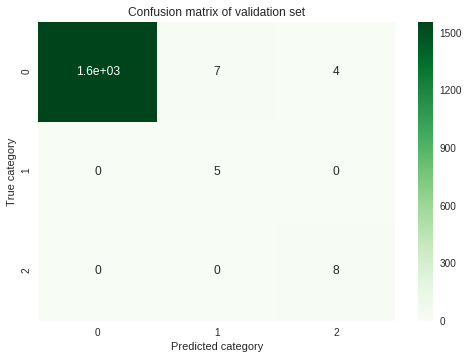

'\nIgnore:           0\nSender Name:      1 \nSender KVK:       2 \nSender IBAN:      3 \nInvoice Reference:4\nTotal:            5\n'

In [26]:
## show confusion matrix
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

cnf_matrix = confusion_matrix(y_true, y_pred)

#abbreviation = ['BG', 'Ch', 'Cl', 'CC', 'CW', 'FH', 'LSB', 'M', 'SM', 'SP', 'SFC', 'SB']
#pd.DataFrame({'class': species, 'abbreviation': abbreviation})

fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Greens, annot=True)
#ax.set_xticklabels(abbreviation)
#ax.set_yticklabels(abbreviation)
plt.title('Confusion matrix of validation set')
plt.ylabel('True category')
plt.xlabel('Predicted category')
plt.show();

'''
Ignore:           0
Sender Name:      1 
Sender KVK:       2 
Sender IBAN:      3 
Invoice Reference:4
Total:            5
'''

Test on many invoices and average the accuracies

In [29]:
#Function to generate random invoices and test the accuracy of the model versus
#the accuracy of the post processing estimations
def test_quality(inv_n,seed=0):
    accuracies = []
    accuracies_clean = []
    '''
    Ignore:           0
    Sender Name:      1 
    Sender KVK:       2 
    Sender IBAN:      3 
    Invoice Reference:4
    Total:            5
    '''
    #Regex patterns
    patterns = [r'[0-9]{8}',
                r'[A-Z]{2}[0-9]{2}[A-Z]{4}[0-9]{10}',
                r'([A-Z]|[0-9]){5}',
                r'€ [0-9]']
    #Paddings around regex search 
    paddings = [1,20,1,5]
    
    #Generate inv_n amount of invoices 
    for i in range(inv_n):
        #Get specific invoice or generate random
        if(seed>0):
          chars,data,y_true = get_invoice(seed)
        else:
          chars,data,y_true = get_invoice()
          
        #Get predicted ys
        y_pred = get_preds(data)
        #Calculate accuracy in percentage
        accuracies.append(sum(1 for x,y in zip(y_true,y_pred) if x == y) / len(y_true))
        
        #Get melted info and clean predictions from small length prediction
        melted,pred =melt_info(chars,y_pred,5)
        
        #Clean name sections
        y_cleaned = cleanNames(chars,y_pred,melted)
        
        #Match regex per category to have more precise estimate
        for j in range(0,4):
            y_cleaned = cleanByRegex(chars,y_cleaned,melted,j+2,patterns[j],paddings[j])
        #Calculate accuracy of cleaned predictions
        accuracies_clean.append(sum(1 for x,y in zip(y_true,y_cleaned) if x == y) / len(y_true))
    print("Accuracy before cleaning: "+str(round(sum(accuracies)/len(accuracies),4)))
    print("Accuracy after cleaning:" +str(round(sum(accuracies_clean)/len(accuracies_clean),4)))

test_quality(100)

#Get example
#test_quality(1,20)

success on 1
success on 4
success on 1
success on 4
success on 1
success on 2
success on 3
success on 4
success on 5
success on 4
success on 1
success on 2
success on 3
success on 5
success on 1
success on 1
success on 2
success on 3
success on 4
success on 5
success on 4
success on 1
success on 2
success on 3
success on 4
success on 5
success on 1
success on 4
success on 1
success on 2
success on 3
success on 5
success on 1
success on 4
success on 1
success on 2
success on 3
success on 4
success on 5
success on 1
success on 1
success on 2
success on 3
success on 4
success on 5
success on 1
success on 1
success on 2
success on 3
success on 4
success on 5
success on 1
success on 1
success on 2
success on 3
success on 4
success on 5
success on 4
success on 1
success on 1
success on 2
success on 3
success on 4
success on 5
success on 1
success on 4
success on 1
success on 2
success on 3
success on 5
success on 1
success on 2
success on 3
success on 5
success on 4
success on 4
success on 1

success on 4
success on 4
success on 1
success on 2
success on 3
success on 4
success on 5
success on 4
success on 1
success on 4
success on 1
success on 4
success on 1
success on 4
success on 1
success on 2
success on 3
success on 4
success on 5
success on 1
success on 1
success on 2
success on 3
success on 4
success on 5
success on 1
success on 2
success on 3
success on 4
success on 5
success on 1
success on 2
success on 3
success on 4
success on 5
success on 1
success on 1
success on 2
success on 3
success on 4
success on 5
success on 1
success on 2
success on 3
success on 4
success on 5
success on 1
success on 4
success on 1
success on 4
success on 4
success on 1
success on 4
success on 1
success on 4
success on 4
success on 1
success on 1
success on 2
success on 3
success on 4
success on 5
success on 1
success on 4
success on 1
success on 4
success on 1
success on 1
success on 2
success on 3
success on 4
success on 5
success on 1
success on 2
success on 3
success on 4
success on 5

## Obtain system outputs from predictions

In [0]:
from itertools import groupby
# Create groups by the predicted output
# The this code will return a tuple with the format
# (category, length, starting index)

# TODO: This code is ugly and very hard to understand
# But it works

# Group by predicted category
g = groupby(enumerate(y_pred), lambda x:x[1])

# Create list of groups
l = [(x[0], list(x[1])) for x in g]

# Create list with tuples of groups
groups = [(x[0], len(x[1]), x[1][0][0]) for x in l]

In [0]:
# Show grouping
groups[:10]

In [0]:
'''
We only want to consider sequences of predictions of the same type 
that have a minimum length. This way we remove the noise
But we also might remove some good predictions

The min length is set to 5 here, certainly a value to experiment with
'''
candidates = []
# Loop over all groups
for group in groups:
    
    # Unpack group
    category, length, index = group
    
    # Ignore the ignore category and only consider category sequences longer than 5
    if category != 0 and length > 5:
        # Create text
        candidate_text = ''.join(chars[index:index+length])
        # Remove line breaks, this is just one way to prettify outputs!
        candidate_text = candidate_text.replace('\n','')
        candidates.append((candidate_text,category))

In [0]:
# Show predictions

'''
Ignore:           0
Sender Name:      1 
Sender KVK:       2 
Sender IBAN:      3 
Invoice Reference:4
Total:            5
'''

sorted(candidates, key=lambda tup: tup[1])